# Task 2

---

## Predictive modeling of customer bookings

This Jupyter notebook includes some code to get you started with this predictive modeling task. We will use various packages for data manipulation, feature engineering and machine learning.

### Exploratory data analysis

First, we must explore the data in order to better understand what we have and the statistical properties of the dataset.

In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler

from xgboost import XGBClassifier

import warnings
warnings.filterwarnings("ignore")

In [19]:
df = pd.read_csv('C:/Users/User/Desktop/Internship Projects/BA Web Scraping Project/data/customer_booking.csv', encoding="ISO-8859-1")
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  object 
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.3+ 

The `.info()` method gives us a data description, telling us the names of the columns, their data types and how many null values we have. Fortunately, we have no null values. It looks like some of these columns should be converted into different data types, e.g. flight_day.

To provide more context, below is a more detailed data description, explaining exactly what each column means:

- `num_passengers` = number of passengers travelling
- `sales_channel` = sales channel booking was made on
- `trip_type` = trip Type (Round Trip, One Way, Circle Trip)
- `purchase_lead` = number of days between travel date and booking date
- `length_of_stay` = number of days spent at destination
- `flight_hour` = hour of flight departure
- `flight_day` = day of week of flight departure
- `route` = origin -> destination flight route
- `booking_origin` = country from where booking was made
- `wants_extra_baggage` = if the customer wanted extra baggage in the booking
- `wants_preferred_seat` = if the customer wanted a preferred seat in the booking
- `wants_in_flight_meals` = if the customer wanted in-flight meals in the booking
- `flight_duration` = total duration of flight (in hours)
- `booking_complete` = flag indicating if the customer completed the booking

Before we compute any statistics on the data, lets do any necessary data conversion

In [21]:
df["flight_day"].unique()

array(['Sat', 'Wed', 'Thu', 'Mon', 'Sun', 'Tue', 'Fri'], dtype=object)

In [22]:
mapping = {
    "Mon": 1,
    "Tue": 2,
    "Wed": 3,
    "Thu": 4,
    "Fri": 5,
    "Sat": 6,
    "Sun": 7,
}

df["flight_day"] = df["flight_day"].map(mapping)

In [23]:
df["flight_day"].unique()

array([6, 3, 4, 1, 7, 2, 5], dtype=int64)

In [24]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
num_passengers,50000.0,1.591240,1.020165,1.00,1.00,1.00,2.00,9.0
purchase_lead,50000.0,84.940480,90.451378,0.00,21.00,51.00,115.00,867.0
length_of_stay,50000.0,23.044560,33.887670,0.00,5.00,17.00,28.00,778.0
flight_hour,50000.0,9.066340,5.412660,0.00,5.00,9.00,13.00,23.0
flight_day,50000.0,3.814420,1.992792,1.00,2.00,4.00,5.00,7.0
wants_extra_baggage,50000.0,0.668780,0.470657,0.00,0.00,1.00,1.00,1.0
wants_preferred_seat,50000.0,0.296960,0.456923,0.00,0.00,0.00,1.00,1.0
wants_in_flight_meals,50000.0,0.427140,0.494668,0.00,0.00,0.00,1.00,1.0
flight_duration,50000.0,7.277561,1.496863,4.67,5.62,7.57,8.83,9.5
booking_complete,50000.0,0.149560,0.356643,0.00,0.00,0.00,0.00,1.0


The `.describe()` method gives us a summary of descriptive statistics over the entire dataset (only works for numeric columns). This gives us a quick overview of a few things such as the mean, min, max and overall distribution of each column.

From this point, you should continue exploring the dataset with some visualisations and other metrics that you think may be useful. Then, you should prepare your dataset for predictive modelling. Finally, you should train your machine learning model, evaluate it with performance metrics and output visualisations for the contributing variables. All of this analysis should be summarised in your single slide.

---
# Exploring Data Analysis

Check for the overall data types.

In [25]:
df.dtypes

num_passengers             int64
sales_channel             object
trip_type                 object
purchase_lead              int64
length_of_stay             int64
flight_hour                int64
flight_day                 int64
route                     object
booking_origin            object
wants_extra_baggage        int64
wants_preferred_seat       int64
wants_in_flight_meals      int64
flight_duration          float64
booking_complete           int64
dtype: object

### Check for any Null Values

In [31]:
df.isnull().sum()

num_passengers           0
sales_channel            0
trip_type                0
purchase_lead            0
length_of_stay           0
flight_hour              0
flight_day               0
route                    0
booking_origin           0
wants_extra_baggage      0
wants_preferred_seat     0
wants_in_flight_meals    0
flight_duration          0
booking_complete         0
dtype: int64

There appears to be no null values.

---

### Plotting a histogram and a kernel density estimate for the given data.

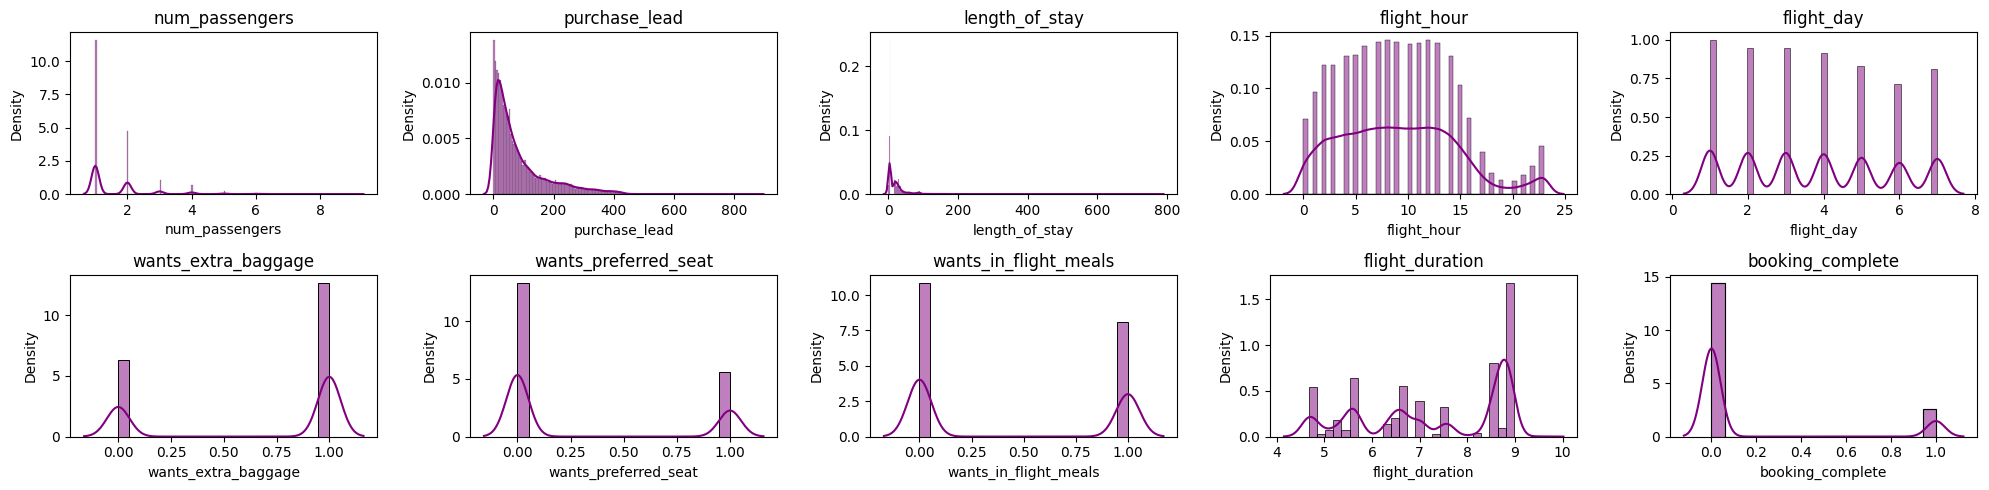

In [41]:
df_int = df.select_dtypes(exclude='object')
plt.figure(figsize=(20,5))
for index, col in enumerate(df_int.columns):
    plt.subplot(2, 5, index+1)
    sns.histplot(df[col], kde=True, stat='density', kde_kws=dict(cut=3), color='purple')
    plt.title(col)

plt.tight_layout()
plt.show()

### Generating a Correlation Diagram

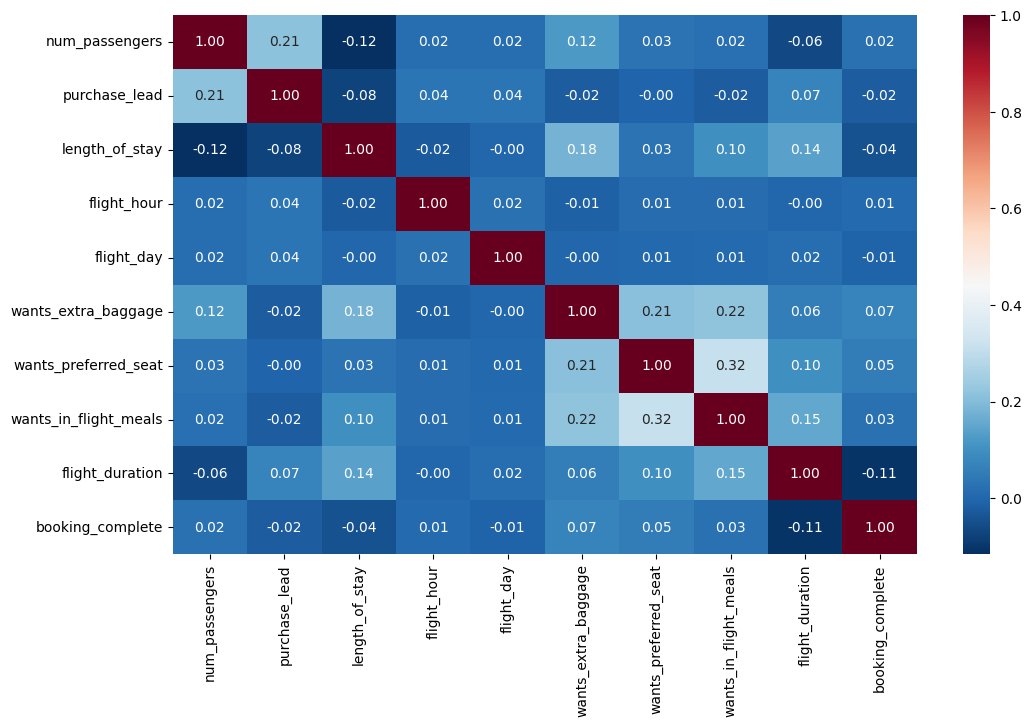

In [57]:
corr = df_int.corr()
plt.subplots(figsize=(12,7))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='RdBu_r', cbar=True)
plt.show()

### Dropping the columns that are not needed

In [58]:
X= df.drop('booking_complete', axis = 1)
y= df.booking_complete

#changing object dtype to int dtype
for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()

In [59]:
X.dtypes

num_passengers             int64
sales_channel              int64
trip_type                  int64
purchase_lead              int64
length_of_stay             int64
flight_hour                int64
flight_day                 int64
route                      int64
booking_origin             int64
wants_extra_baggage        int64
wants_preferred_seat       int64
wants_in_flight_meals      int64
flight_duration          float64
dtype: object

### Finding the Mutual Information Score of Each Features with Respect to the Target Variable Y

In [64]:
mi_scores = mutual_info_classif(X, y)
mi_scores = pd.Series(mi_scores, name = "MI Scores", index = X.columns)
mi_scores = mi_scores.sort_values(ascending=False)

mi_scores

route                    0.055287
booking_origin           0.048874
flight_duration          0.017046
wants_extra_baggage      0.010768
length_of_stay           0.008713
wants_in_flight_meals    0.008014
wants_preferred_seat     0.004033
flight_day               0.003156
flight_hour              0.003096
num_passengers           0.002086
sales_channel            0.002061
trip_type                0.000722
purchase_lead            0.000334
Name: MI Scores, dtype: float64

### Plotting the Mutual Information

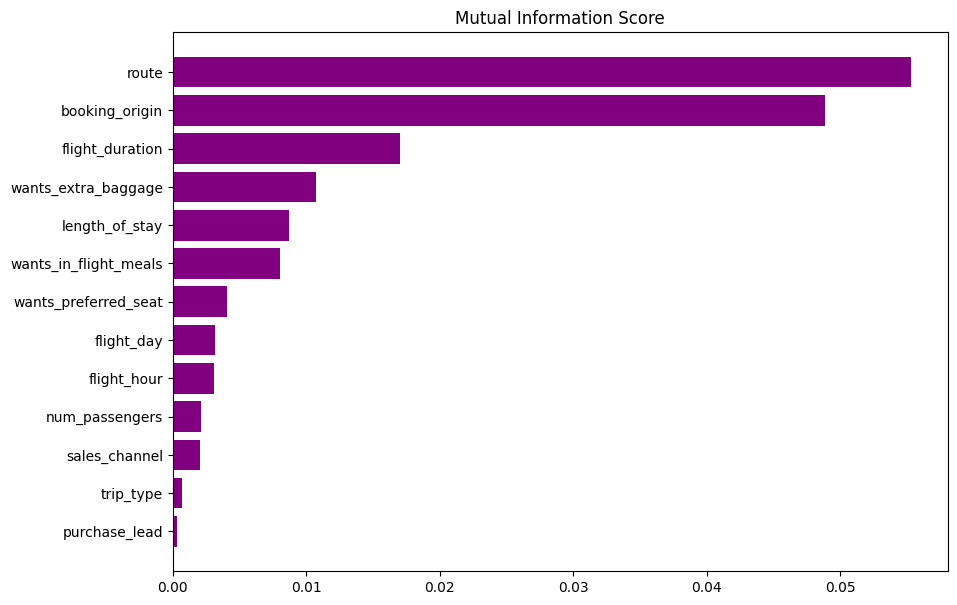

In [85]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores, color="Purple")
    plt.yticks(width, ticks)
    plt.title("Mutual Information Score")

plt.figure(dpi=100, figsize=(10,7))
plot_mi_scores(mi_scores)

We can see the top 5 features which are dependant with booking_complete feature
1. route
2. booking_origin
3. flight_duration
4. wants_extra_baggage
5. length_of_stay

### Splitting the Data and Training it

In [66]:
# Function for the dataset split
def dataset(X,y):
    train_full_X, val_X, train_full_y, val_y = train_test_split(X, y, test_size=0.2, random_state=0)

    # Using the same function as the previous one for the validation set
    train_X, test_X, train_y, test_y = train_test_split(train_full_X, train_full_y, test_size=0.25, random_state=0)
    return (train_X, val_X, train_y, val_y)

### Defining the transformers for feature engineering with scaling

In [67]:
def scale(X):
    scaler = MinMaxScaler()
    scaler.fit(X)
    return X

# Creating Different Model for Analysis

---


## Model 1: Random Forest Classifier with Top 6 Features

In [70]:
# Assigning the features in a list
features = ['route', 'booking_origin', 'flight_duration', 'wants_extra_baggage', 'length_of_stay', 'num_passengers']
X= df[features]

# One hot encoding
X= pd.get_dummies(X, columns=features)
X= scale(X)
y = df.booking_complete

X_train, X_val, y_train, y_val = dataset(X, y)

forest_model = RandomForestClassifier(random_state=1)
forest_model.fit(X_train, y_train)
preds = forest_model.predict(X_val)

print('Accuracy: ', accuracy_score(y_val, preds) * 100)
print('AUC Score: ', roc_auc_score(y_val, preds))

Accurary:  83.36
AUC Score:  0.5657818407546988


## Model 2: Random Forest Classifier With All Features

In [72]:
X = df.drop('booking_complete', axis=1)

# One hot encoding
X= pd.get_dummies(X)
X= scale(X)
y = df.booking_complete

X_train, X_val, y_train, y_val = dataset(X, y)

forest_model = RandomForestClassifier(random_state=1)
forest_model.fit(X_train, y_train)
preds = forest_model.predict(X_val)

print('Accuracy: ', accuracy_score(y_val, preds) * 100)
print('AUC Score: ', roc_auc_score(y_val, preds))

Accuracy:  84.84
AUC Score:  0.5527766076821664


---

## Model 3: XGB Classifier with 6 Features

In [75]:
X = df[features]

# One hot encoding
X = pd.get_dummies(X, columns=features)
X = scale(X)

y = df.booking_complete

X_train, X_val, y_train, y_val = dataset(X, y)
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)
prediction_xgb = xgb_model.predict(X_val)

print('Accuracy: ', accuracy_score(y_val, prediction_xgb) * 100)
print('AUC Score: ', roc_auc_score(y_val, prediction_xgb))

Accuracy:  84.78999999999999
AUC Score:  0.5231540310747802


## Model 4: XGB Classifier with All Features


In [76]:
X = df.drop('booking_complete', axis=1)

# One hot encoding
X = pd.get_dummies(X)
X = scale(X)

y = df.booking_complete

X_train, X_val, y_train, y_val = dataset(X, y)
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)
prediction_xgb = xgb_model.predict(X_val)

print('Accuracy: ', accuracy_score(y_val, prediction_xgb) * 100)
print('AUC Score: ', roc_auc_score(y_val, prediction_xgb))

Accuracy:  84.87
AUC Score:  0.5358453436541607


---

### The Random Forest Predictor with all the features will be chosen as the final model to compare with the test data. It has a similar accuracy to the XGB classifier but it's AUC score is better than the other models.


## Validating Test Data

In [77]:
X= df.drop('booking_complete',axis=1)

#one hot encoding
X = pd.get_dummies(X)
X= scale(X)

y= df.booking_complete
train_full_X,test_X, train_full_y, test_y = train_test_split(X, y,test_size=0.2,random_state = 0)

forest_model= RandomForestClassifier(random_state=1)
forest_model.fit(train_full_X, train_full_y)
preds= forest_model.predict(test_X)

print('ACCURACY: ',accuracy_score(test_y,preds)*100)
print('AUC score: ',roc_auc_score(test_y,preds))


ACCURACY:  85.37
AUC score:  0.5678474780954598


---

# Conclusion

In this project we dealt with an unbalanced dataset, with large categorical data:

1. We first handled the categorical data by mapping the small level categorical data, and we applied the Target encoding technique for the large categorical features, also we used the StandardScaler to scale some features.

2. To handle the unbalanced dataset we used oversampling and under sampling techniques to make our train data balanced and ready to be fitted in the model.

Then we trained 2 models:

- RandomForest Classifier
- XgBoost Classifier

We trained each model twice, first on the 6 features and second on all the features to compare results. The Random Forest Classifier with all the features were chosen to be the best model to use for the test data. Afterwards, an accuracy of 85.37 resulted when comparing the test data.